# Deep-Q-Learning

In this notebook I explore the concepts of Deep-Q-Learning by following the papers published DeepMind [V. Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf) and [V. Mnih et al (2015)](https://www.nature.com/articles/nature14236/).

As I'm intrigued by the topic of autonomous driving, the [MIT lecture videos by Lex Fridman](https://deeplearning.mit.edu/) introduced me to the topic of DQL motivated me to take a deep dive and get familiar with its concepts.

### !!!This is still a work in progress!!!

**To do:** \
**1. Restructure the code in a more handy way.**


In [2]:
import gym
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Flatten, Dense

import typing

import time

import matplotlib.pyplot as plt

from skimage.transform import resize
from PIL import Image

## Preview of the game

Use **left** and **right arrows** to move the spaceship sideways and the **space bar** to use the main cannon and shoot the aliens!

If you want to move to the left/right and shoot simultaneously then use **s/d**.

As you play, the `PlayPlot` function (marked deprecated) will plot the immediate award for the actions you take. For this uncomment the callback call in the `play` function. 

In [2]:
import pygame
from gym.utils.play import play, PlayPlot

def compute_metrics(obs_t, obs_tp, action, reward, terminated, truncated, info):
    return [reward, np.linalg.norm(action)]

plotter = PlayPlot(
    compute_metrics,
    horizon_timesteps=200,
    plot_names=["Immediate Rew.", "Action Magnitude"]
)

my_env = gym.make("SpaceInvaders-v4", render_mode="rgb_array")
mapping = {(pygame.K_SPACE,): 1, (pygame.K_RIGHT,): 2, (pygame.K_LEFT,): 3, (pygame.K_d,): 4, (pygame.K_s,): 5}
play(my_env, keys_to_action=mapping) #, callback=plotter.callback)

/home/hare/.local/lib/python3.10/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SpaceInvaders-v4 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/SpaceInvaders-v5`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


## Starting to define some functions

For the first attempt we'll use the architecture of the neural network described on page 6 in [Volodymir Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf).

### Preprocess function $\phi$

Since it will be computationally more demanding working with the raw $210 \times 160$ pixel frames, we'll apply a preprocess function $\phi$ to the frames before forwarding them to the neural network. The preprocess function will do the following
- (will not be done here) for a single frame we take the maximum value for each pixel color value and the previous frame (removes flickering in original paper, but we'll use the `ALE/SpaceInvaders-v5` environment which has a frameskip=5 which removes the flickering of the misiles)
- the frames will be converted from RGB representation into gray-scale
- the frames will be resized to $110 \times 84$ images
- the playing area is cropped out so we have a final $84 \times 84$ frame (this is done in, but I might skip this step in this notebook [Volodymir Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf))
- the last 4 frames from a sequence will be modified as explained and stacked to form a $84 \times 84 \times 4$ input for the agent

So, to preprocess our input for the neuarl network, we'll need a function $\phi$ that will take the previous processed sequence $\phi_t$ and new obtained frame $x_{t+1}$ and combine them to a new processed sequence as follows

$$\phi: \phi_t, x_{t+1} \longrightarrow \phi_{t+1}$$

In [17]:
"""First we create some annotations for the raw frame, processed frame and processed state."""

from typing import Generic, TypeVar, Annotated
from typing_extensions import TypeVarTuple, Unpack

ArrayType = TypeVar('ArrayType')
Shape = TypeVarTuple('Shape')
Dtype = TypeVar('Dtype')

class Array(Generic[ArrayType, Shape, Dtype]):
    pass

RawFrame = Array[np.ndarray, (210, 160, 3), np.uint8]
ProcessedFrame = Array[tf.Tensor, (84,84,1), tf.uint8]
ProcessedState = Array[tf.Tensor, (84,84,4), tf.uint8]

In [18]:
class Preprocessor:
    """
    Takes care of preprocessing frames for the DQN models.
    """
    
    def __init__(self, height:int=84, width:int=84):
        self.height = height
        self.width = width
        
    def initialize_state(self, env) -> ProcessedState:
        """
        Initializes the first state of an episode with the first 4 frames.
        """
        env.reset()
        actions = [env.action_space.sample() for i in range(5)]
        raw_frames = [env.step(action)[0] for action in actions]
        processed_frames = [self.preprocess_frame(raw_frames[idx], raw_frames[idx+1]) for idx in range(4)]
        
        return tf.concat(processed_frames, axis=-1), raw_frames[-1]
        
        
    def encode_frames(self,
                      new_raw_obs:RawFrame,
                      old_raw_obs:RawFrame
                     )-> RawFrame:
        
        """Encodes two consecutive frames in such a manner to remove the flickering of projectiles."""

        return np.array([old_raw_obs, new_raw_obs]).max(axis=0)    
    
    def preprocess_frame(self,
                         new_raw_obs:RawFrame,
                         old_raw_obs:RawFrame
                        ) -> ProcessedFrame:
        """
        Preprocesses one frame for the model.
        """
        
        processed_fr = self.encode_frames(old_raw_obs, new_raw_obs)
        processed_fr = tf.image.rgb_to_grayscale(processed_fr)
        processed_fr = tf.image.crop_to_bounding_box(processed_fr, 34, 0, 160, 160)
        processed_fr = tf.image.resize(processed_fr, [self.height, self.width], method='bilinear')
        processed_fr = tf.cast(processed_fr, tf.uint8)

        return processed_fr
        
    
    def new_state(self,
                  new_raw_obs:RawFrame,
                  old_raw_obs:RawFrame,
                  old_state:ProcessedState
                 ) -> ProcessedState:
        """
        Creates a news state from an old state and a new raw frame.
        """
        processed_fr = self.preprocess_frame(new_raw_obs, old_raw_obs)
        
        return tf.concat([old_state[::, ::, 1:], processed_fr], axis=-1)

### Replay memory

The replay memory $D$ stores following information (called *transition* $\phi$) after every taken action

$$\left( \phi_t, \ a_t, \ r_t, \ \phi_{t+1} \right) \longrightarrow D$$

where
- $\phi_t$ is the preprocessed sequence including the frame at time step $t$
- $a_t$ is the action taken at time step $t$
- $r_t$ is the reward gained at time step $t$ after taking action $a_t$ in state $\phi_t$ $t$
- $\phi_{t+1}$ is the preprocessed sequence including the new state we reached after taking action $a_t$

In [9]:
class ReplayMemory:
    def __init__(self, capacity:int, minibatch_size:int):
        """Initiate a ReplayMemory object with capacity, memories and minibatch_size properties"""
        
        self.capacity = capacity
        self.memories = []
        self.minibatch_size = minibatch_size
        
    def store_transition(self,
                         curr_state:ProcessedState,
                         curr_action:int,
                         reward:float,
                         new_state:ProcessedState,
                         lives:int):
        """Stores a transition in ReplayMemory object."""
        
        self.memories.append([curr_state, curr_action, reward, new_state, lives])
        if (len(self.memories) > self.capacity):
            self.memories.pop(0)

    def sample_minibatch(self):
        """Samples a minibatch of transitions from ReplayMemory object."""
        
        return random.sample(self.memories, self.minibatch_size)
    
    def get_memories(self):
        return self.memories
    
    def get_count_of_memories(self):
        return len(self.memories)

### Testing the preprocess function $\phi$

In [10]:
## get some observations to test the preprocess function
## first 45 memory entries are before the game starts

def get_sample_frames(name="ALE/SpaceInvaders-v5", frameskip=5):

    memory_raw = []
    memory_processed = []
    memory_encoded = []

    some_preprocessor = Preprocessor()
    
    if frameskip:
        env = gym.make(name, frameskip=frameskip, render_mode="rgb_array")
    else:
        env = gym.make(name, render_mode="rgb_array")
        
    preprocessed, curr_raw_obs = some_preprocessor.initialize_state(env)
    memory_processed.append(preprocessed)
    memory_raw.append(curr_raw_obs)
    for _ in range(500):
        action = env.action_space.sample()
        new_raw_obs, reward, terminated, info = env.step(action)# new_raw_obs, reward, terminated, truncated, info = env.step(action)

        preprocessed = some_preprocessor.new_state(new_raw_obs, curr_raw_obs, memory_processed[-1])
        memory_processed.append(preprocessed)
        
        encoded = some_preprocessor.encode_frames(new_raw_obs, curr_raw_obs)
        memory_encoded.append(encoded)
        
        curr_raw_obs = new_raw_obs
        memory_raw.append(curr_raw_obs)

        if terminated: # or truncated:
            observation = env.reset() #observation, info = env.reset()
    env.close()
    return memory_raw, memory_processed, memory_encoded

In [11]:
# defining a couple of functions to check the original and processed frames
    # check if the flickering is a problem in consecutive images
    # check if the misiles are seen in the processed images


def plot_raw_frames(frames):

    fig = plt.figure(figsize=(10, 10))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        img = frames[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    
def plot_processed_frames(frames):

    fig = plt.figure(figsize=(10, 10))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        img = frames[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img[::, ::, 2])
    plt.show()

### Defining the agent

Text about the DQN model coming soon.

- create a target model updater
- check why accuracy always 0% -> because its not a categorical problem
- create an evaluation process
- get an output gif/video of the model actually playing

In [19]:
"""
Using keras.layers we can build a Sequential model with a last layer being a Dense
one with a number of neurons being equal to the number of actions the agent can 
take while playing SpaceInvaders. To train our DQN model we are interested in the
maximal value of the neurons in the Dense layer and its index.

To extract this information we define a custom MaxValAndAction layer for our model.
This layer will return the index of the neuron with the maximal value. The index
corresponds to the action in the action space of SpaceInvaders while the value of
the neuron corresponds to the Q-value.
"""

huber = tf.keras.losses.Huber()

class MaxValAndAction(keras.layers.Layer):
        def __init__(self):
            super(MaxValAndAction, self).__init__()
        
        def __call__(self, values):
            action = tf.cast(tf.math.argmax(values, axis=1), dtype=tf.float64)
            max_value = tf.cast(tf.math.reduce_max(values, axis=1), dtype=tf.float64)
            
            return tf.stack([max_value, action], axis=1)
        
def custom_loss(y_true, y_pred):
    """
    Since y_true and y_pred will have different shapes
        - y_true shape -> (batch_size, 1) second axis contains only the maxval (Q-value)
        - y_pred shape -> (batch_size, 2) second axis contains (maxval(Q-value), action)-pair
    we need to crete a custom loss function. The loss function will implement the Huber-loss
    function and will ignore the action-value from the second axis of y_pred.
    """
    
    loss = huber(y_true[::,0], y_pred[::,0])
    return loss

class DQNmodel:
    def __init__(self, n_actions:int, learning_rate:float=0.001, state_shape:tuple=(84,84,4)):
        """
        Initiates a DQNmodel object. The object will contain a keras Sequential model according
        to the proposed architecture in Volodymir Mnih et al (2015).
        """
        
        self.model = keras.Sequential()
        
        self.model.add(Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same", activation="relu", input_shape=state_shape))
        self.model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", activation="relu"))
        self.model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
        self.model.add(Flatten())
        self.model.add(Dense(512, activation="relu"))
        self.model.add(Dense(n_actions, activation="linear"))
        self.model.add(MaxValAndAction())
        
        self.model.compile(loss=custom_loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    
    def best_action(self, new_state:ProcessedState) -> int:
        model_prediction = self.model.predict(new_state, verbose=0)
        return int(model_prediction[0][1])
    
    def predict(self, new_state:ProcessedState) -> int:
        model_prediction = self.model.predict(new_state, verbose=0)
        return model_prediction[0][0]
    
    def get_weights(self):
        return self.model.get_weights()
    
    def set_weights(self, weights):
        self.model.set_weights(weights)
        
    def update_step(self, target_model, replay_memory:replay_memory) -> float:
        """
        Args:
            target_model                
        """
        # sample minibatch of transitions
        minibatch = replay_memory.sample_minibatch()
        target_q = []
        X = []

        # for each transition we need a target value Q
        for (idx, (curr_state, curr_action, reward, new_state, lives)) in enumerate(minibatch):
            X.append(curr_state)
            if lives == 0:
                target_q.append(reward)
            else:
                new_state = tf.expand_dims(new_state, axis=0)
                target_pred = target_model.predict(new_state)
                target_q.append(reward + discount * target_pred)

        # update the weights of the main model with target values Q
        training_info = self.model.fit(x=np.array(X), y=np.array(target_q), epochs=1, verbose=0)
        return training_info.history['loss'][0]


### Exploration and exploitation with $\epsilon$-greedy strategy

- explore for rand < eps and exploit for rand > eps
- for first xx amount of frames $\epsilon = 1$
- for the next million frames $\epsilon \rightarrow 0.1$ linearly
- after that it is fixed to $\epsilon = 0.1$

In [20]:
class ExplorationVsExploitation:
    """
    This class handles the epsilon-greedy strategy which will be used to determine whether
    we will choose an action to explore new possibilites or exploit the accumulated experience.
    """
    def __init__(self,
                 dqn_model:DQNmodel,
                 n_actions:int,
                 eps_initial:float=1.0,
                 eps_final:float=0.1,
                 start_fr:int=5000,
                 end_fr:int=1000000,
                 evaluation:bool=False):
        """
        Initiates an ExplorationVsExploitation object with a DQNmodel object and hyperparameters.
        """
        self.eps_initial = eps_initial
        self.eps_final = eps_final
        self.start_fr = start_fr
        self.end_fr = end_fr
        self.slope = (self.eps_initial - self.eps_final) / (self.start_fr - self.end_fr)
        self.intercept = eps_initial - self.slope * self.start_fr
        
        self.n_actions = n_actions
        
        self.dqn_model = dqn_model
        
        self.evaluation = evaluation
        
        
    def __call__ (self, curr_state:ProcessedState, frame_num:int=0) -> int:
        """
        When the object is called, it will return an action to be performed by the agent.
        This action will either be an exploration of new possibilities or and exploitation
        of the accumulated experience of the agent.
        """
        if self.evaluation:
            eps = 0
        elif frame_num <= self.start_fr:
            eps = self.eps_initial
        elif self.start_fr < frame_num < self.end_fr:
            eps = self.slope * frame_num + self.intercept
        elif frame_num >= self.end_fr:
            eps = self.eps_final

        
        if np.random.rand() < eps:
            # we explore
            return np.random.randint(self.n_actions)
        else:
            # we choose the action yielding the highest reward according to our main model
            model_prediction = self.dqn_model.best_action(tf.expand_dims(curr_state, axis=0))
            return model_prediction


In [25]:
my_env = gym.make("ALE/SpaceInvaders-v5", frameskip=5, render_mode="rgb_array")
obs_shape = my_env.observation_space.shape
num_actions = my_env.action_space.n

memory_size = 10**4
max_frames = 500#5 * 10**4
minibatch_size = 32
update_target_freq = 0.25 * 10**4    ## update target NN 2500 frames
discount = 0.99
update_main_freq = 4
average_loss_freq = 400
learning_rate = 0.001

memory_warm_up = 200

## Training the model with the Deep-Q-learning Algorithm

Training details:
- We will follow [V. Mnih et al (2015)](https://www.nature.com/articles/nature14236/) and normalize the positive, neutral and negative rewards to 1, 0, -1 respectively

<img src="./images/DQL-algorithm-2015.png" alt="dql" width="850"/>

In [22]:
def normalize_rewards(rew):
    return 1 if rew > 0 else -1 if rew < 0 else 0    

In [23]:
## initialize action-value function Q with random weights
M_model = DQNmodel(num_actions)

## initialize action-value target function with same weights 
T_model = DQNmodel(num_actions)
T_model.set_weights(M_model.get_weights())

2022-12-20 16:01:30.745360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hare/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-20 16:01:30.745710: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-20 16:01:30.745746: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc2713): /proc/driver/nvidia/version does not exist
2022-12-20 16:01:30.746808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
def train_DQL():
    ## initialize replay memory D
    memories = replay_memory(memory_size, minibatch_size)
    
    ## initialize epsilon greedy scheduler
    explore_vs_exploit = ExplorationVsExploitation(M_model, num_actions)
    
    ## initialize frame preprocessor
    Frame_processor = Preprocessor()

    memory_count = frame_num = 0
    
    losses = []
    averaged_losses = []
    rewards = []
    
    ## start training until we reach the maximal number of frames
    while (frame_num < max_frames):
        
        episode_reward = 0

        ## initialise first sequence of episode
        curr_state, curr_raw_obs = Frame_processor.initialize_state(my_env)
        alive = True
        
        while alive:
            
            ## choose an exploration/explotation action 
            curr_action = explore_vs_exploit(curr_state, frame_num)
            
            ## take action
            new_raw_obs, reward, terminated, info = my_env.step(curr_action) ##truncated
            
            if info["lives"] == 0:
                alive = False
            
            episode_reward += reward

            reward = normalize_rewards(reward)

            ## create new sequence with new frame
            new_state = Frame_processor.new_state(new_raw_obs, curr_raw_obs, curr_state)

            ## store new transition
            memories.store_transition(curr_state, curr_action, reward, new_state, info["lives"])
            memory_count +=1
            
            ## perform weights update for main model
            if frame_num % update_main_freq == 0 and frame_num > memory_warm_up:
                loss = M_model.update_step(T_model, memories)
                losses.append(loss)
            
            ## perform weights update for target model
            if frame_num % update_target_freq == 0 and frame_num > memory_warm_up:
                T_model.set_weights(M_model.get_weights())
                print("Updating target model...")
                
            if frame_num % average_loss_freq == 0 and frame_num > memory_warm_up:
                averaged_losses.append(np.mean(losses))
                losses = []
                print("Finished ", frame_num, " frames. Loss: ", averaged_losses[-1])

            curr_state = new_state
            curr_raw_obs = new_raw_obs
            frame_num += 1

        rewards.append(episode_reward)
        
    return averaged_losses, rewards
            

In [27]:
start = time.time()
training_losses, training_rewards = train_DQL()
end = time.time()
print("Elapsed time in minutes: ", (end-start)/60)

Finished  400  frames. Loss:  3.332992051243782
Finished  800  frames. Loss:  0.20252899944782257
Elapsed time in minutes:  4.553891575336456


In [ ]:
with open(r'./losses.txt', 'w') as fp:
    for loss in training_losses:
        # write each item on a new line
        fp.write("%s\n" % loss)
    print('Done')
    
with open(r'./rewards.txt', 'w') as fp:
    for reward in training_rewards:
        # write each item on a new line
        fp.write("%s\n" % reward)
    print('Done')

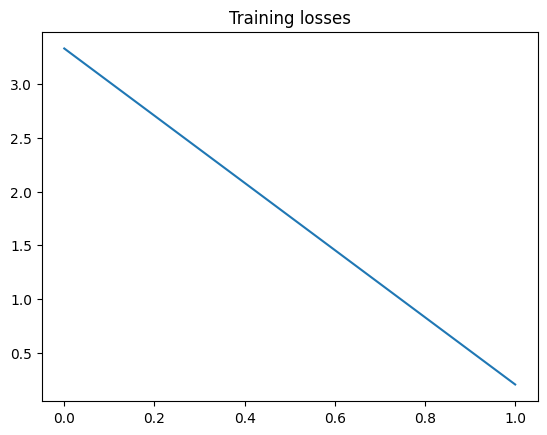

In [28]:
plt.plot(training_losses)
plt.title('Training losses')

plt.show()

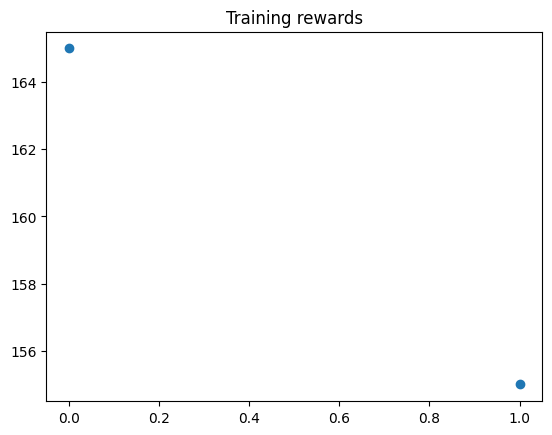

In [30]:
plt.plot(training_rewards, 'o')
plt.title('Training rewards')

plt.show()

In [31]:
def export_as_gif(frames:list, name:str):
    resized_frames = [resize(frame, (420, 320, 3), preserve_range=True, order=0).astype(np.uint8) for frame in frames]
    
    images = [Image.fromarray(frame) for frame in resized_frames]
    
    images[0].save(name, save_all=True, append_images=images[1:], duration=100, loop=0)

In [53]:
def evaluate_DQL():
    ## initialize epsilon greedy scheduler
    explore_vs_exploit = ExplorationVsExploitation(M_model, num_actions, evaluation=True)
    
    ## initialize frame preprocessor
    Frame_processor = Preprocessor()

    rewards = []
    frames_for_gif = []
    num_of_ep = 1
    
    ## start outer loop of the number of episode we'll train the model for
    for episode in range(5):
        
        episode_reward = 0
        alive = True

        ## initialise first sequence of new episode
        curr_state, curr_raw_obs = Frame_processor.initialize_state(my_env)
        
        while alive:
            
            ## choose an exploration/explotation action 
            curr_action = explore_vs_exploit(curr_state)
            
            ## take action
            new_raw_obs, reward, terminated, truncated, info = my_env.step(curr_action)
            
            if info["lives"] == 0:
                alive = False
            
            frames_for_gif.append(new_raw_obs)
            
            episode_reward += reward

            ## create new sequence with new frame
            curr_state = Frame_processor.new_state(new_raw_obs, curr_raw_obs, curr_state)
            curr_raw_obs = new_raw_obs
               
        
        rewards.append(episode_reward)
        name = "eval_" + str(num_of_ep) + ".gif"
        export_as_gif(frames_for_gif, name)
        frames_for_gif = []
        num_of_ep += 1

    return rewards
            

In [54]:
evaluation_rewards = evaluate_DQL()

In [ ]:
plt.plot(eval_rew, 'o')
plt.title('Evaluation rewards')

plt.show()